In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
%pylab inline

/Users/d3r3zz3d/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Search directory for all jpgs and returns a list
mylist = os.listdir("./1000subset/MorphII_cropped")
#Converts list into numpy array
mylist = np.array(mylist)
##Builds a an array of all zeros
lab = np.zeros((len(mylist),), dtype=np.int)
lab = np.resize(lab,(1000,2))

In [3]:
#Searchs strings in mylist for M (male) and returns value of 1 if exists and 0 for female if doesn't exist
for i in range(len(mylist)):
    if "M" in mylist[i]:
        lab[i,0] = 1
        lab[i,1] = 0
    else:
        lab[i,0] = 0
        lab[i,1] = 1


In [4]:
print(lab[100:110,])

[[1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]]


In [5]:
print(mylist[100:110,])

['190416_02M32.JPG' '135085_00M42.JPG' '318932_04F28.JPG' '116196_2M42.JPG'
 '164777_01M30.JPG' '121338_07M35.JPG' '304740_12F35.JPG' '109504_1M34.JPG'
 '052581_0M45.JPG' '199335_05M32.JPG']


In [6]:
#Find list of all filenames in directory
import glob
filelist = glob.glob('./1000subset/MorphII_cropped/*.JPG')
#Convert images into numpy arrays
train = np.array([np.array(Image.open(fname)) for fname in filelist])
#Transforms the 3d array into a 2d array (1000,4200)
train = train.reshape((train.shape[0],-1))
#buils batchs of training and label data


train_batch = tf.train.batch([train], batch_size=100)
label_batch = tf.train.batch([lab], batch_size=100)

In [7]:
print(train)

[[181 187 186 ..., 182 143 104]
 [230 242 246 ..., 156 128 113]
 [154 160 168 ..., 164 145 119]
 ..., 
 [ 78 117 151 ..., 123 125 146]
 [192 193 186 ...,  66  69  70]
 [ 23  37  76 ...,  16   9  27]]


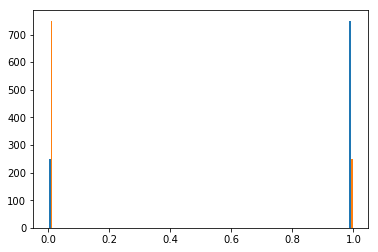

In [8]:
plt.hist(lab, 62)
plt.show()

In [9]:
#Build a function to convert training data and labels into mini-batches of user-defined size
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)



Xtr, Ytr = next_batch(100, train, lab)
print(Ytr.shape)

(100, 2)


In [10]:
x = tf.placeholder(tf.float32, [1000, 4200])

#layer 1
W1 = tf.Variable(tf.zeros([4200, 100]))
b1 = tf.Variable(tf.zeros([100]))
y1 = tf.matmul(x, W1) + b1 


#layer 2
W2 = tf.Variable(tf.zeros([100, 2]))
b2 = tf.Variable(tf.zeros([2]))
y2 = tf.nn.softmax(tf.matmul(y1, W2) + b2)

#output
y = y2
y_ = tf.placeholder(tf.float32, [1000, 2])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

In [44]:
x = tf.placeholder(tf.float32, [1000, 4200])

W = tf.Variable(tf.zeros([4200, 2]))
b = tf.Variable(tf.zeros([2]))

y = tf.nn.relu(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [1000,2])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=None))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

In [14]:
sess.run(y,feed_dict={x:train})

array([[ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       ..., 
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5]], dtype=float32)

In [11]:
sess = tf.InteractiveSession()

tf.global_variables_initializer().run()

for _ in range(100):
    sess.run(cross_entropy, feed_dict={x: train, y_: lab})

In [46]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
print(tf.argmax(y,1),tf.arg_max(y_,1))
print(cross_entropy)

Tensor("ArgMax_36:0", shape=(1000,), dtype=int64) Tensor("ArgMax_37:0", shape=(1000,), dtype=int64)
Tensor("Mean_8:0", shape=(), dtype=float32)


In [17]:
accur = tf.reduce_mean(tf.cast(y[,1] == y_[,1], tf.float32))
print(sess.run(accur, feed_dict={x: train, y_: lab}))

SyntaxError: invalid syntax (<ipython-input-17-2c65adb2096c>, line 1)

In [14]:
#Compare
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={x: train, y_: lab}))

0.75


In [26]:
print(accuracy)

Tensor("Mean_4:0", shape=(), dtype=float32)


In [82]:
import tensorflow as tf
from __future__ import division, print_function, unicode_literals

config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300, 100], n_classes=1,
                                         feature_columns=feature_cols, config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)  # if TensorFlow >= 1.1
dnn_clf.fit(train, lab, batch_size=50, steps=40000) 

AttributeError: module 'pandas' has no attribute 'computation'

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test)
accuracy_score(y_test, y_pred['classes'])

In [18]:
x = tf.placeholder(tf.float32, [None, 4200])

W = tf.Variable(tf.zeros([4200, 10]))
b = tf.Variable(tf.zeros([10]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [None, 1])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [20]:
sess = tf.InteractiveSession()

tf.global_variables_initializer().run()

for _ in range(5):
  sess.run(train_step, feed_dict={x: train_batch, y_: label_batch})

TypeError: The value of a feed cannot be a tf.Tensor object. Acceptable feed values include Python scalars, strings, lists, numpy ndarrays, or TensorHandles.

In [ ]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)
    
hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

In [ ]:
reset_graph()

n_inputs = 60 * 70  # MorphII
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 2

In [ ]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [ ]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [ ]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [ ]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

In [ ]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")